In [1]:
from __future__ import print_function
import ipywidgets as widgets
from transformers import pipeline
# from simpletransformers.t5 import T5Model, T5Args
import pandas as pd
import logging
import numpy as np
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
import json
import random
# Pull reddit data from reddit api
import requests
from bs4 import BeautifulSoup
import math
#tf for RNN
import tensorflow_datasets as tfds
import tensorflow as tf

In [2]:
df = pd.read_csv('similar_subreddits_500_df.csv')
#df = pd.read_csv('handpicked_subreddits_500_df.csv')
#df = pd.read_csv('random_subreddits_500_df.csv')

df.head()

,Unnamed: 0,subreddit,text,label
0,0,gaming,Who is you favorite sidekick?,0
1,1,gaming,Crystal Dynamics announces the next Tomb Raide...,0
2,2,gaming,Epic launches Unreal Engine 5,0
3,3,gaming,Found journal that says Cecilia and Ruth are a...,0
4,4,gaming,Got a new tat and wanted to share with my fell...,0


In [3]:
# Check if there is body text in reddit post
print(df['text'][0])

Who is you favorite sidekick?


In [4]:
# Check if total is correct per subreddit
df['subreddit'].value_counts()

gaming             500
PS4                500
pokemon            500
xboxone            500
leagueoflegends    500
Name: subreddit, dtype: int64

In [5]:
possible_labels = df.subreddit.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'gaming': 0, 'PS4': 1, 'pokemon': 2, 'xboxone': 3, 'leagueoflegends': 4}

In [6]:
#de-slang text
slang = pd.read_csv('slangit.csv')
slangit_dict = slang.set_index('Slang Term').to_dict()
slangit_dict = slangit_dict['Meaning']

def slang_lookup(text, dictionary):
    
    try:
        pattern = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in dictionary.keys()) + r')(?!\w)')
        result = pattern.sub(lambda x: dictionary[x.group()], text)
    except:
        result = text

    return result

df['text'] = df['text'].apply(lambda x: slang_lookup(x, slangit_dict))

df['text'].head()

0                        Who is you favorite sidekick?
1    Crystal Dynamics announces the next Tomb Raide...
2                        Epic launches Unreal Engine 5
3    Found journal that says Cecilia and Ruth are a...
4    Got a new tat and wanted to share with my fell...
Name: text, dtype: object

In [7]:
df['label'] = df.subreddit.replace(label_dict)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.20, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [9]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [10]:
df.groupby(['subreddit', 'label', 'data_type']).count()

Unnamed: 0  text
subreddit       label data_type                  
PS4             1     train             400   400
                      val               100   100
gaming          0     train             400   400
                      val               100   100
leagueoflegends 4     train             400   400
                      val               100   100
pokemon         2     train             400   400
                      val               100   100
xboxone         3     train             400   400
                      val               100   100

In [11]:
df.head()

,Unnamed: 0,subreddit,text,label,data_type
0,0,gaming,Who is you favorite sidekick?,0,train
1,1,gaming,Crystal Dynamics announces the next Tomb Raide...,0,val
2,2,gaming,Epic launches Unreal Engine 5,0,train
3,3,gaming,Found journal that says Cecilia and Ruth are a...,0,train
4,4,gaming,Got a new tat and wanted to share with my fell...,0,train


In [12]:
train_dataset = df[df.data_type == 'train']
val_dataset = df[df.data_type == 'val']

train_dataset = train_dataset.drop(['subreddit','data_type'], axis = 1)
val_dataset = val_dataset.drop(['subreddit','data_type'], axis = 1)
train_X, train_Y = train_dataset['text'], train_dataset['label']
test_X, test_Y = val_dataset['text'], val_dataset['label']
hot_train_Y = pd.get_dummies(train_dataset.label)
hot_test_Y = pd.get_dummies(val_dataset.label)
hot_test_Y


,0,1,2,3,4
1,1,0,0,0,0
13,1,0,0,0,0
20,1,0,0,0,0
21,1,0,0,0,0
34,1,0,0,0,0
...,...,...,...,...,...
2467,0,0,0,0,1
2471,0,0,0,0,1
2488,0,0,0,0,1
2489,0,0,0,0,1


In [13]:
test_X

1       Crystal Dynamics announces the next Tomb Raide...
13                           Best Team-Building Exercise?
20      I own a ps4 and xbone, what are some games i c...
21               The Absolute Hardest Enemy in Elden Ring
34                                  Loved this questline.
                              ...                        
2467    &amp;#x200B;\n\n[POV: You play ADC in 2022](ht...
2471    Trying to find a new main, i like tanks, but a...
2488    Last night and today every single queue is tak...
2489                How to get to get shredded as a gamer
2492    Sorry if this has been asked already, but if p...
Name: text, Length: 500, dtype: object

In [14]:
labels = tf.constant(train_Y)
features = tf.constant(train_X)

train_dataset_tf = tf.data.Dataset.from_tensor_slices((features,labels))
#train_dataset_tf = tf.data.Dataset.from_tensor_slices(dict(train_dataset))
print(train_dataset_tf.element_spec)

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [15]:
#test vectorization
for example, label in train_dataset_tf.take(1):
    print('text: ', example.numpy())
    print()
    print('label: ', label.numpy())


text:  b'Who is you favorite sidekick?'

label:  0


In [16]:
labels_val = tf.constant(test_Y)
features_val = tf.constant(test_X)

val_dataset_tf = tf.data.Dataset.from_tensor_slices((features_val,labels_val))
print(val_dataset_tf)

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>


In [17]:
#test vectorization
for example, label in val_dataset_tf.take(1):
    print('text: ', example.numpy())
    print()
    print('label: ', label.numpy())

text:  b'Crystal Dynamics announces the next Tomb Raider, built in Unreal Engine 5'

label:  0


In [18]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [19]:
train_dataset_tf = train_dataset_tf.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset_tf = val_dataset_tf.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [20]:
#create text encoder
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset_tf.map(lambda text, labels: text))

In [21]:
#make RNN model

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=128,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    #bidirectional expects 3D input
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=False)),
    tf.keras.layers.Dense(32,activation = 'relu'),
    tf.keras.layers.Dense(5,activation = 'softmax'), 
    # tf.keras.layers.Dense(1, activation = 'softmax')
])

In [22]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])
        
        

In [23]:
#training not working because the input doesn't fit. There shouldn't be anything empty, null, or Nan so maybe an exploding gradient?
history = model.fit(train_X, hot_train_Y, epochs=3, batch_size = 64, validation_data=(test_X, hot_test_Y))

Epoch 1/3
32/32 [==============================] - 49s 1s/step - loss: 1.5987 - accuracy: 0.2460 - val_loss: 1.5656 - val_accuracy: 0.3220
Epoch 2/3
32/32 [==============================] - 38s 1s/step - loss: 1.4079 - accuracy: 0.4540 - val_loss: 1.3196 - val_accuracy: 0.4740
Epoch 3/3
32/32 [==============================] - 37s 1s/step - loss: 0.9741 - accuracy: 0.6135 - val_loss: 1.0337 - val_accuracy: 0.6120


In [24]:
preds = model.predict(test_X)
y_pred = np.argmax(preds, axis = 1)

In [25]:
import sklearn
precision, recall, f1, _ = sklearn.metrics.precision_recall_fscore_support(test_Y, y_pred, average = 'micro')
print(f'Precision: {precision}\nRecall: {recall}\nF1: {f1}')

Precision: 0.612
Recall: 0.612
F1: 0.612


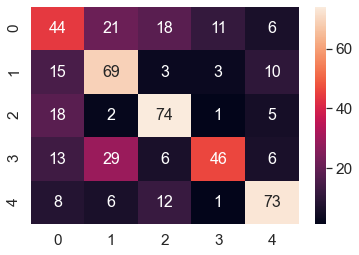

In [26]:
import seaborn as sn
import matplotlib.pyplot as plt

array = sklearn.metrics.confusion_matrix(test_Y, y_pred)
#print(cm)

df_cm = pd.DataFrame(array, range(5), range(5))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()



(0.0, 1.629966276884079)

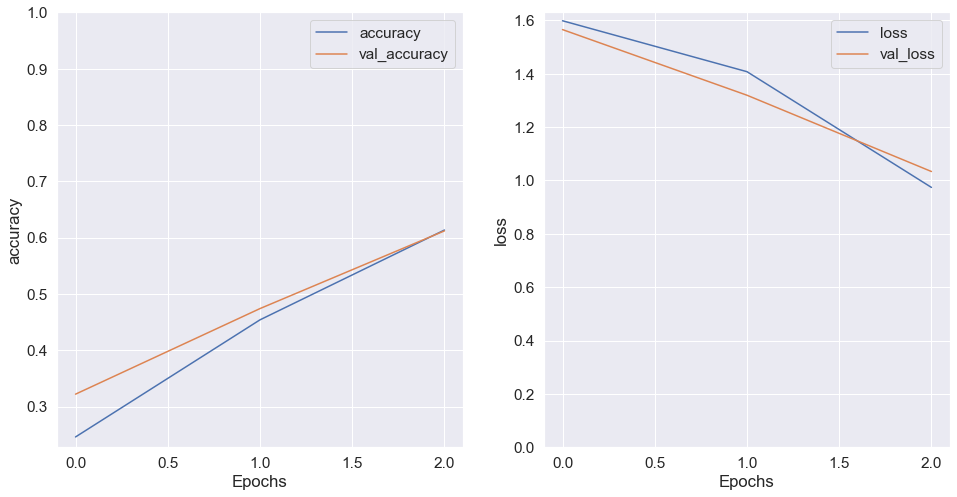

In [28]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)